<a href="https://colab.research.google.com/github/sarehsoltani/AI-ClassicalSearchAlgorithms/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Change PATH to working directory on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, confusion_matrix
import mlflow
import optuna
import mlflow.keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [20]:
pip install optuna

In [21]:
pip install mlflow

In [25]:
mlflow.set_tracking_uri('/content/drive/MyDrive/ECG Classification/mlruns')

In [22]:
# Load training and test data
x_train = pd.read_csv("/content/drive/MyDrive/ECG Classification/data/processed/x_train.csv", header=None)
y_train = pd.read_csv("/content/drive/MyDrive/ECG Classification/data/processed/y_train.csv", header=None)
x_test = pd.read_csv("/content/drive/MyDrive/ECG Classification/data/processed/x_test.csv", header=None)
y_test = pd.read_csv("/content/drive/MyDrive/ECG Classification/data/processed/y_test.csv", header=None)

In [23]:
# Convert to NumPy arrays and reshape for the CNN model
X_train = x_train.values[..., np.newaxis]  # Adding channel dimension
Y_train = y_train.values.astype(np.int8)

X_test = x_test.values[..., np.newaxis]  # Adding channel dimension
Y_test = y_test.values.astype(np.int8)

## Model Selection

For the **ECG Heartbeat Categorization** task, we selected a **1D Convolutional Neural Network (CNN)** as the model architecture. This choice was based on the following factors:

### Rationale Behind Choosing 1D CNN:
- **1D ECG Signals**: ECG signals are one-dimensional time-series data, making **1D convolutions** an ideal choice for learning local patterns (e.g., P-waves, QRS complexes, and T-waves).
- **Local Feature Extraction**: CNNs excel at automatically extracting features from raw ECG data without the need for manual feature engineering.
- **Efficiency**: Compared to more complex models like RNNs or LSTMs, **1D CNNs** are computationally efficient, allowing for faster training and inference.

### Potential Challenges:
- **Overfitting**: The model might overfit the training data if it learns noise or irrelevant patterns. This can be addressed using techniques such as **dropout**, **early stopping**, and **data augmentation**.
- **Data Imbalance**: The dataset might have class imbalance, which could cause the model to be biased toward the majority class. We addressed this by using **SMOTE** and **class weighting**.


In [29]:
# Define the CNN model with hyperparameters
def get_model(learning_rate, batch_size):
    nclass = 5  # Number of output classes
    inp = Input(shape=(187, 1))  # Input shape: (187 time-steps, 1 channel)

    # Convolutional layers
    x = Conv1D(16, kernel_size=5, activation='relu', padding='valid')(inp)
    x = Conv1D(16, kernel_size=5, activation='relu', padding='valid')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(x)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(x)
    x = Conv1D(32, kernel_size=3, activation='relu', padding='valid')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(rate=0.1)(x)

    x = Conv1D(256, kernel_size=3, activation='relu', padding='valid')(x)
    x = Conv1D(256, kernel_size=3, activation='relu', padding='valid')(x)
    x = GlobalMaxPooling1D()(x)  # Global Max Pooling
    x = Dropout(rate=0.2)(x)

    # Fully connected layers
    x = Dense(64, activation='relu', name="dense_1")(x)
    x = Dense(64, activation='relu', name="dense_2")(x)
    x = Dense(nclass, activation='softmax', name="dense_3_mitbih")(x)

    # Model compilation
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()  # Print the model summary
    return model


## Overfitting and Underfitting Mitigation

To address **overfitting** and **underfitting** during training, we employed several techniques:

- **Regularization**: We used **dropout layers** with a dropout rate of 0.1 to reduce overfitting by randomly deactivating neurons during training.
- **Early Stopping**: This stops training when the validation performance stops improving, preventing the model from overfitting on the training data.
- **Data Augmentation**: We augmented the data using techniques SMOTE to expose the model to a wider range of data patterns, making it more robust.



## Early Stopping and Callbacks

We implemented the following **callbacks** to improve training efficiency and prevent overfitting:

- **Early Stopping**: Stops the training process when the validation accuracy stops improving for a specified number of epochs, which helps prevent overfitting.
- **Model Checkpoint**: Saves the model’s best weights during training, ensuring we retain the best model based on validation performance.
- **Reduce Learning Rate on Plateau**: Reduces the learning rate when the validation accuracy stops improving, allowing the model to fine-tune its weights.

## Hyperparameter Tuning with Optuna and MLFlow

In this task, **Optuna** is used to optimize the hyperparameters of the **ECG classification model**, and **MLFlow** is integrated to log the hyperparameters, metrics, and the model throughout the process.

### Objective Function for Hyperparameter Optimization

We define the **objective function** for **Optuna**, which samples different combinations of hyperparameters and trains the model using those hyperparameters. The hyperparameters being optimized are:
- **Learning Rate** (sampled from a log-uniform distribution between `1e-5` and `1e-2`)
- **Batch Size** (sampled from a categorical list of `[32, 64, 128]`)

We run Optuna to search for the best hyperparameters based on the F1 score. The optimization process runs multiple trials, with each trial using different hyperparameter combinations.

In [31]:
def plot_learning_curves(history):
    """
    Plot learning curves for training and validation accuracy/loss
    """
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plot
    plt.show()

[I 2025-03-03 03:33:18,515] A new study created in memory with name: no-name-33286cf4-25d4-460c-b3d9-1324f551d786
<ipython-input-32-953aa02cc7db>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_40 (Conv1D)                   │ (None, 183, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 179, 16)             │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 87, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 85, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 40, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 38, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_46 (Conv1D)                   │ (None, 17, 256)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 15, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_mitbih (Dense)               │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,901 (995.71 KB)

 Trainable params: 254,901 (995.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.97537, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 29s - 10ms/step - accuracy: 0.7238 - loss: 0.6924 - val_accuracy: 0.9754 - val_loss: 0.0803 - learning_rate: 4.6724e-04
Epoch 2/100

Epoch 2: val_accuracy improved from 0.97537 to 0.98130, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 13s - 5ms/step - accuracy: 0.8729 - loss: 0.3470 - val_accuracy: 0.9813 - val_loss: 0.0650 - learning_rate: 4.6724e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.98130 to 0.98623, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 20s - 7ms/step - accuracy: 0.9059 - loss: 0.2612 - val_accuracy: 0.9862 - val_loss: 0.0445 - learning_rate: 4.6724e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.98623 to 0.98733, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 21s - 7ms/step - accuracy: 0.9256 - loss: 0.2100 - val_accuracy: 0.9873 - val_loss: 0.0383 - learning_rate: 4.6724e-04
Epoch 5/100

Epoch 5: val_accuracy improved from 0.98733 to 0.98784, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 21s - 8ms/step - accuracy: 0.9360 - loss: 0.1788 - val_accuracy: 0.9878 - val_loss: 0.0373 - learning_rate: 4.6724e-04
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.98784
2798/2798 - 12s - 4ms/step - accuracy: 0.9449 - loss: 0.1545 - val_accuracy: 0.9866 - val_loss: 0.0375 - learning_rate: 4.6724e-04
Epoch 7/100

Epoch 7: val_accuracy improved from 0.98784 to 0.99176, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 13s - 5ms/step - accuracy: 0.9507 - loss: 0.1380 - val_accuracy: 0.9918 - val_loss: 0.0238 - learning_rate: 4.6724e-04
Epoch 8/100

Epoch 8: val_accuracy did not improve from 0.99176
2798/2798 - 19s - 7ms/step - accuracy: 0.9570 - loss: 0.1218 - val_accuracy: 0.9887 - val_loss: 0.0337 - learning_rate: 4.6724e-04
Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.99176
2798/2798 - 12s - 4ms/step - accuracy: 0.9614 - loss: 0.1099 - val_accuracy: 0.9904 - val_loss: 0.0267 - learning_rate: 4.6724e-04
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.99176

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.672427312470973e-05.
2798/2798 - 12s - 4ms/step - accuracy: 0.9651 - loss: 0.0993 - val_accuracy: 0.9896 - val_loss: 0.0279 - learning_rate: 4.6724e-04
Epoch 11/100

Epoch 11: val_accuracy improved from 0.99176 to 0.99487, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 21s - 7ms/step - accuracy: 0.9759 - loss: 0.0695 - val_accuracy: 0.9949 - val_loss: 0.0140 - learning_rate: 4.6724e-05
Epoch 12/100

Epoch 12: val_accuracy improved from 0.99487 to 0.99527, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 20s - 7ms/step - accuracy: 0.9786 - loss: 0.0624 - val_accuracy: 0.9953 - val_loss: 0.0139 - learning_rate: 4.6724e-05
Epoch 13/100

Epoch 13: val_accuracy improved from 0.99527 to 0.99538, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 21s - 8ms/step - accuracy: 0.9797 - loss: 0.0582 - val_accuracy: 0.9954 - val_loss: 0.0129 - learning_rate: 4.6724e-05
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.99538
2798/2798 - 20s - 7ms/step - accuracy: 0.9807 - loss: 0.0564 - val_accuracy: 0.9954 - val_loss: 0.0146 - learning_rate: 4.6724e-05
Epoch 15/100

Epoch 15: val_accuracy improved from 0.99538 to 0.99628, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 20s - 7ms/step - accuracy: 0.9808 - loss: 0.0544 - val_accuracy: 0.9963 - val_loss: 0.0110 - learning_rate: 4.6724e-05
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.99628
2798/2798 - 12s - 4ms/step - accuracy: 0.9809 - loss: 0.0547 - val_accuracy: 0.9961 - val_loss: 0.0122 - learning_rate: 4.6724e-05
Epoch 17/100

Epoch 17: val_accuracy improved from 0.99628 to 0.99668, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 13s - 5ms/step - accuracy: 0.9820 - loss: 0.0525 - val_accuracy: 0.9967 - val_loss: 0.0115 - learning_rate: 4.6724e-05
Epoch 18/100

Epoch 18: val_accuracy improved from 0.99668 to 0.99688, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


2798/2798 - 21s - 7ms/step - accuracy: 0.9822 - loss: 0.0509 - val_accuracy: 0.9969 - val_loss: 0.0117 - learning_rate: 4.6724e-05
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.99688
2798/2798 - 12s - 4ms/step - accuracy: 0.9825 - loss: 0.0497 - val_accuracy: 0.9969 - val_loss: 0.0112 - learning_rate: 4.6724e-05
Epoch 20/100

Epoch 20: val_accuracy did not improve from 0.99688
2798/2798 - 12s - 4ms/step - accuracy: 0.9832 - loss: 0.0483 - val_accuracy: 0.9967 - val_loss: 0.0112 - learning_rate: 4.6724e-05
Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.99688

Epoch 21: ReduceLROnPlateau reducing learning rate to 4.67242716695182e-06.
2798/2798 - 20s - 7ms/step - accuracy: 0.9832 - loss: 0.0496 - val_accuracy: 0.9966 - val_loss: 0.0112 - learning_rate: 4.6724e-05
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.99688
2798/2798 - 11s - 4ms/step - accuracy: 0.9844 - loss: 0.0454 - val_accuracy: 0.9969 - val_loss: 0.0108 - learning_rate: 4.6724e-06
Epoc

2798/2798 - 12s - 4ms/step - accuracy: 0.9850 - loss: 0.0439 - val_accuracy: 0.9972 - val_loss: 0.0106 - learning_rate: 4.6724e-06
Epoch 24/100

Epoch 24: val_accuracy did not improve from 0.99719
2798/2798 - 12s - 4ms/step - accuracy: 0.9851 - loss: 0.0437 - val_accuracy: 0.9969 - val_loss: 0.0113 - learning_rate: 4.6724e-06
Epoch 25/100

Epoch 25: val_accuracy did not improve from 0.99719
2798/2798 - 12s - 4ms/step - accuracy: 0.9845 - loss: 0.0451 - val_accuracy: 0.9969 - val_loss: 0.0105 - learning_rate: 4.6724e-06
Epoch 26/100

Epoch 26: val_accuracy did not improve from 0.99719

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.6724271669518207e-07.
2798/2798 - 20s - 7ms/step - accuracy: 0.9849 - loss: 0.0438 - val_accuracy: 0.9970 - val_loss: 0.0102 - learning_rate: 4.6724e-06
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.99719
2798/2798 - 21s - 7ms/step - accuracy: 0.9845 - loss: 0.0444 - val_accuracy: 0.9969 - val_loss: 0.0102 - learning_rate: 4.6724e-07
Ep

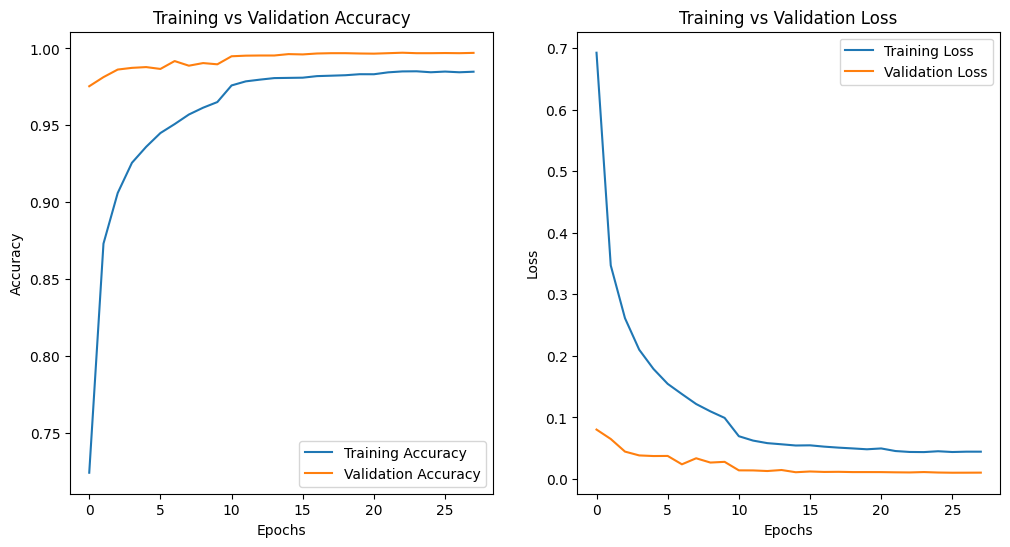

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


2025/03/03 03:41:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/03 03:41:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-03-03 03:41:33,776] Trial 0 finished with value: 0.8167811812222985 and parameters: {'learning_rate': 0.0004672427378539449, 'batch_size': 32}. Best is trial 0 with value: 0.8167811812222985.
<ipython-input-32-953aa02cc7db>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Test Precision: 0.7574
Test Recall: 0.9278
Test F1 Score: 0.8168
Test Accuracy: 0.9537
Test AUC-ROC: 0.9911


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_48 (Conv1D)                   │ (None, 183, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 179, 16)             │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 87, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 85, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_52 (Conv1D)                   │ (None, 40, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 38, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_54 (Conv1D)                   │ (None, 17, 256)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 15, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_mitbih (Dense)               │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,901 (995.71 KB)

 Trainable params: 254,901 (995.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 18s - 25ms/step - accuracy: 0.3087 - loss: 1.5381 - val_accuracy: 0.0000e+00 - val_loss: 1.9561 - learning_rate: 1.7178e-05
Epoch 2/100

Epoch 2: val_accuracy improved from 0.00000 to 0.00060, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 11s - 16ms/step - accuracy: 0.4655 - loss: 1.3413 - val_accuracy: 6.0320e-04 - val_loss: 1.6780 - learning_rate: 1.7178e-05
Epoch 3/100

Epoch 3: val_accuracy improved from 0.00060 to 0.48949, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.5522 - loss: 1.1778 - val_accuracy: 0.4895 - val_loss: 1.2282 - learning_rate: 1.7178e-05
Epoch 4/100

Epoch 4: val_accuracy improved from 0.48949 to 0.67679, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.6087 - loss: 1.0356 - val_accuracy: 0.6768 - val_loss: 0.9407 - learning_rate: 1.7178e-05
Epoch 5/100

Epoch 5: val_accuracy improved from 0.67679 to 0.90067, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 5ms/step - accuracy: 0.6549 - loss: 0.9200 - val_accuracy: 0.9007 - val_loss: 0.5404 - learning_rate: 1.7178e-05
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.90067
700/700 - 5s - 7ms/step - accuracy: 0.7019 - loss: 0.8103 - val_accuracy: 0.8999 - val_loss: 0.4317 - learning_rate: 1.7178e-05
Epoch 7/100

Epoch 7: val_accuracy improved from 0.90067 to 0.90640, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.7322 - loss: 0.7344 - val_accuracy: 0.9064 - val_loss: 0.3556 - learning_rate: 1.7178e-05
Epoch 8/100

Epoch 8: val_accuracy improved from 0.90640 to 0.92008, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.7535 - loss: 0.6832 - val_accuracy: 0.9201 - val_loss: 0.2856 - learning_rate: 1.7178e-05
Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.92008
700/700 - 5s - 7ms/step - accuracy: 0.7666 - loss: 0.6448 - val_accuracy: 0.9192 - val_loss: 0.2834 - learning_rate: 1.7178e-05
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.92008
700/700 - 4s - 5ms/step - accuracy: 0.7805 - loss: 0.6133 - val_accuracy: 0.9142 - val_loss: 0.2928 - learning_rate: 1.7178e-05
Epoch 11/100

Epoch 11: val_accuracy did not improve from 0.92008

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.7177781046484597e-06.
700/700 - 5s - 7ms/step - accuracy: 0.7911 - loss: 0.5848 - val_accuracy: 0.9196 - val_loss: 0.2624 - learning_rate: 1.7178e-05
Epoch 12/100

Epoch 12: val_accuracy improved from 0.92008 to 0.92339, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.7970 - loss: 0.5673 - val_accuracy: 0.9234 - val_loss: 0.2447 - learning_rate: 1.7178e-06
Epoch 13/100

Epoch 13: val_accuracy improved from 0.92339 to 0.92490, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.7986 - loss: 0.5643 - val_accuracy: 0.9249 - val_loss: 0.2398 - learning_rate: 1.7178e-06
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.92490
700/700 - 4s - 5ms/step - accuracy: 0.7984 - loss: 0.5626 - val_accuracy: 0.9221 - val_loss: 0.2507 - learning_rate: 1.7178e-06
Epoch 15/100

Epoch 15: val_accuracy did not improve from 0.92490
700/700 - 4s - 5ms/step - accuracy: 0.7996 - loss: 0.5602 - val_accuracy: 0.9192 - val_loss: 0.2630 - learning_rate: 1.7178e-06
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.92490

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.7177781046484598e-07.
700/700 - 6s - 8ms/step - accuracy: 0.7994 - loss: 0.5577 - val_accuracy: 0.9219 - val_loss: 0.2517 - learning_rate: 1.7178e-06
Epoch 17/100

Epoch 17: val_accuracy did not improve from 0.92490
700/700 - 4s - 6ms/step - accuracy: 0.8014 - loss: 0.5567 - val_accuracy: 0.9229 - val_loss: 0.2475 - learning_rate: 1.7178e-07
Epoch 18/100

Epo

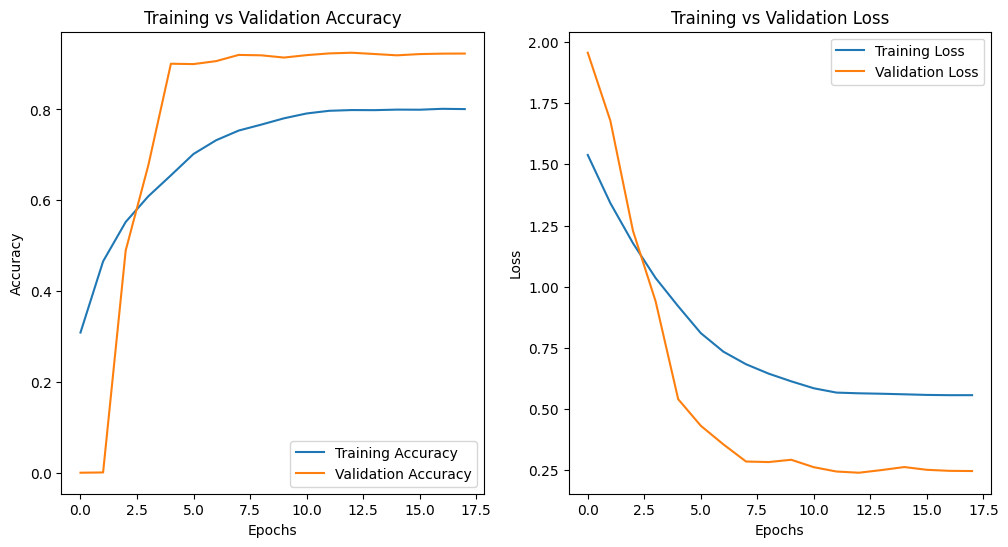

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


2025/03/03 03:43:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/03 03:43:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-03-03 03:43:26,345] Trial 1 finished with value: 0.54538625070882 and parameters: {'learning_rate': 1.717778019522087e-05, 'batch_size': 128}. Best is trial 0 with value: 0.8167811812222985.
<ipython-input-32-953aa02cc7db>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Test Precision: 0.5054
Test Recall: 0.8146
Test F1 Score: 0.5454
Test Accuracy: 0.7437
Test AUC-ROC: 0.9448


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_56 (Conv1D)                   │ (None, 183, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_57 (Conv1D)                   │ (None, 179, 16)             │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_58 (Conv1D)                   │ (None, 87, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 85, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_60 (Conv1D)                   │ (None, 40, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 38, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 17, 256)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 15, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_7               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_mitbih (Dense)               │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,901 (995.71 KB)

 Trainable params: 254,901 (995.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.83482, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 20s - 28ms/step - accuracy: 0.5970 - loss: 1.0083 - val_accuracy: 0.8348 - val_loss: 0.5479 - learning_rate: 2.7852e-04
Epoch 2/100

Epoch 2: val_accuracy improved from 0.83482 to 0.91354, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 5ms/step - accuracy: 0.8109 - loss: 0.5359 - val_accuracy: 0.9135 - val_loss: 0.2656 - learning_rate: 2.7852e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.91354 to 0.94591, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 5s - 7ms/step - accuracy: 0.8531 - loss: 0.4137 - val_accuracy: 0.9459 - val_loss: 0.1671 - learning_rate: 2.7852e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.94591 to 0.94843, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.8765 - loss: 0.3442 - val_accuracy: 0.9484 - val_loss: 0.1477 - learning_rate: 2.7852e-04
Epoch 5/100

Epoch 5: val_accuracy improved from 0.94843 to 0.97768, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.8917 - loss: 0.3011 - val_accuracy: 0.9777 - val_loss: 0.0813 - learning_rate: 2.7852e-04
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.97768
700/700 - 5s - 8ms/step - accuracy: 0.9039 - loss: 0.2686 - val_accuracy: 0.9658 - val_loss: 0.1005 - learning_rate: 2.7852e-04
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.97768
700/700 - 4s - 6ms/step - accuracy: 0.9140 - loss: 0.2387 - val_accuracy: 0.9777 - val_loss: 0.0722 - learning_rate: 2.7852e-04
Epoch 8/100

Epoch 8: val_accuracy improved from 0.97768 to 0.98070, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 5s - 8ms/step - accuracy: 0.9207 - loss: 0.2219 - val_accuracy: 0.9807 - val_loss: 0.0600 - learning_rate: 2.7852e-04
Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.98070
700/700 - 4s - 6ms/step - accuracy: 0.9266 - loss: 0.2032 - val_accuracy: 0.9762 - val_loss: 0.0755 - learning_rate: 2.7852e-04
Epoch 10/100

Epoch 10: val_accuracy improved from 0.98070 to 0.98593, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.9322 - loss: 0.1895 - val_accuracy: 0.9859 - val_loss: 0.0451 - learning_rate: 2.7852e-04
Epoch 11/100

Epoch 11: val_accuracy did not improve from 0.98593
700/700 - 4s - 5ms/step - accuracy: 0.9380 - loss: 0.1754 - val_accuracy: 0.9849 - val_loss: 0.0493 - learning_rate: 2.7852e-04
Epoch 12/100

Epoch 12: val_accuracy improved from 0.98593 to 0.99085, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 6s - 9ms/step - accuracy: 0.9418 - loss: 0.1621 - val_accuracy: 0.9909 - val_loss: 0.0321 - learning_rate: 2.7852e-04
Epoch 13/100

Epoch 13: val_accuracy did not improve from 0.99085
700/700 - 4s - 5ms/step - accuracy: 0.9453 - loss: 0.1527 - val_accuracy: 0.9902 - val_loss: 0.0336 - learning_rate: 2.7852e-04
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.99085
700/700 - 5s - 7ms/step - accuracy: 0.9478 - loss: 0.1439 - val_accuracy: 0.9898 - val_loss: 0.0347 - learning_rate: 2.7852e-04
Epoch 15/100

Epoch 15: val_accuracy improved from 0.99085 to 0.99196, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 7s - 10ms/step - accuracy: 0.9510 - loss: 0.1368 - val_accuracy: 0.9920 - val_loss: 0.0311 - learning_rate: 2.7852e-04
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.99196
700/700 - 4s - 5ms/step - accuracy: 0.9526 - loss: 0.1315 - val_accuracy: 0.9901 - val_loss: 0.0364 - learning_rate: 2.7852e-04
Epoch 17/100

Epoch 17: val_accuracy improved from 0.99196 to 0.99336, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 5ms/step - accuracy: 0.9552 - loss: 0.1253 - val_accuracy: 0.9934 - val_loss: 0.0244 - learning_rate: 2.7852e-04
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.99336
700/700 - 4s - 6ms/step - accuracy: 0.9583 - loss: 0.1176 - val_accuracy: 0.9911 - val_loss: 0.0280 - learning_rate: 2.7852e-04
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.99336
700/700 - 5s - 6ms/step - accuracy: 0.9589 - loss: 0.1150 - val_accuracy: 0.9922 - val_loss: 0.0271 - learning_rate: 2.7852e-04
Epoch 20/100

Epoch 20: val_accuracy improved from 0.99336 to 0.99527, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 4s - 6ms/step - accuracy: 0.9611 - loss: 0.1090 - val_accuracy: 0.9953 - val_loss: 0.0182 - learning_rate: 2.7852e-04
Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.99527
700/700 - 5s - 8ms/step - accuracy: 0.9625 - loss: 0.1044 - val_accuracy: 0.9935 - val_loss: 0.0234 - learning_rate: 2.7852e-04
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.99527
700/700 - 4s - 5ms/step - accuracy: 0.9648 - loss: 0.0999 - val_accuracy: 0.9938 - val_loss: 0.0206 - learning_rate: 2.7852e-04
Epoch 23/100

Epoch 23: val_accuracy did not improve from 0.99527

Epoch 23: ReduceLROnPlateau reducing learning rate to 2.7852089260704815e-05.
700/700 - 4s - 5ms/step - accuracy: 0.9657 - loss: 0.0960 - val_accuracy: 0.9951 - val_loss: 0.0188 - learning_rate: 2.7852e-04
Epoch 24/100

Epoch 24: val_accuracy improved from 0.99527 to 0.99608, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 7s - 10ms/step - accuracy: 0.9724 - loss: 0.0792 - val_accuracy: 0.9961 - val_loss: 0.0152 - learning_rate: 2.7852e-05
Epoch 25/100

Epoch 25: val_accuracy improved from 0.99608 to 0.99618, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


700/700 - 10s - 14ms/step - accuracy: 0.9725 - loss: 0.0762 - val_accuracy: 0.9962 - val_loss: 0.0150 - learning_rate: 2.7852e-05
Epoch 26/100

Epoch 26: val_accuracy did not improve from 0.99618
700/700 - 4s - 6ms/step - accuracy: 0.9747 - loss: 0.0723 - val_accuracy: 0.9952 - val_loss: 0.0183 - learning_rate: 2.7852e-05
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.99618
700/700 - 5s - 7ms/step - accuracy: 0.9743 - loss: 0.0722 - val_accuracy: 0.9956 - val_loss: 0.0164 - learning_rate: 2.7852e-05
Epoch 28/100

Epoch 28: val_accuracy did not improve from 0.99618

Epoch 28: ReduceLROnPlateau reducing learning rate to 2.7852089260704816e-06.
700/700 - 4s - 5ms/step - accuracy: 0.9747 - loss: 0.0718 - val_accuracy: 0.9961 - val_loss: 0.0161 - learning_rate: 2.7852e-05
Epoch 29/100

Epoch 29: val_accuracy did not improve from 0.99618
700/700 - 5s - 8ms/step - accuracy: 0.9754 - loss: 0.0692 - val_accuracy: 0.9960 - val_loss: 0.0162 - learning_rate: 2.7852e-06
Epoch 30/100

E

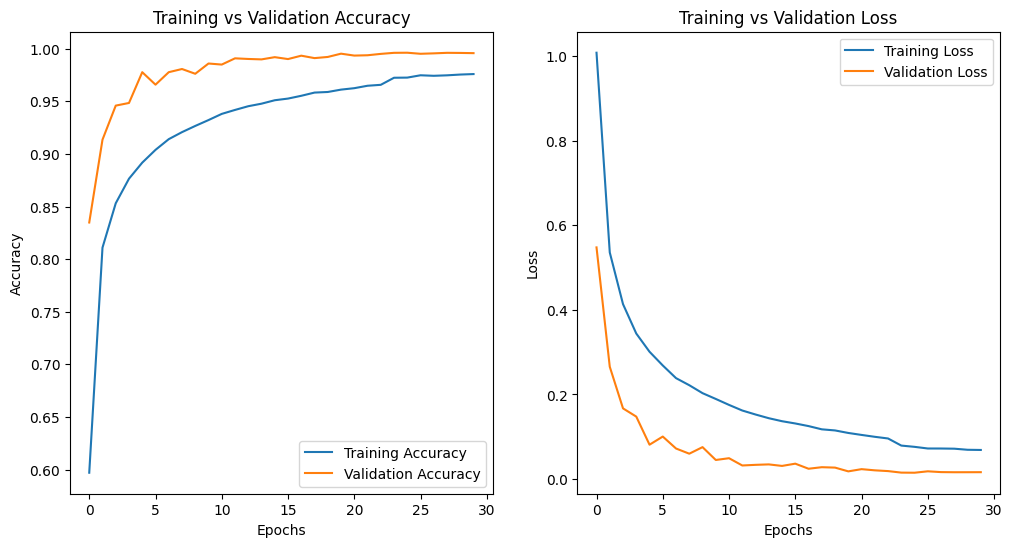

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025/03/03 03:46:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/03 03:46:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-03-03 03:46:19,752] Trial 2 finished with value: 0.775253571952224 and parameters: {'learning_rate': 0.0002785208823644249, 'batch_size': 128}. Best is trial 0 with value: 0.8167811812222985.
<ipython-input-32-953aa02cc7db>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Test Precision: 0.7164
Test Recall: 0.9218
Test F1 Score: 0.7753
Test Accuracy: 0.9397
Test AUC-ROC: 0.9910


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_64 (Conv1D)                   │ (None, 183, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_65 (Conv1D)                   │ (None, 179, 16)             │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_66 (Conv1D)                   │ (None, 87, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 85, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_68 (Conv1D)                   │ (None, 40, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_69 (Conv1D)                   │ (None, 38, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 17, 256)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 15, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_8               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_mitbih (Dense)               │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,901 (995.71 KB)

 Trainable params: 254,901 (995.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.90258, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 20s - 14ms/step - accuracy: 0.7104 - loss: 0.7245 - val_accuracy: 0.9026 - val_loss: 0.3065 - learning_rate: 0.0066
Epoch 2/100

Epoch 2: val_accuracy improved from 0.90258 to 0.95134, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 6s - 5ms/step - accuracy: 0.8500 - loss: 0.4145 - val_accuracy: 0.9513 - val_loss: 0.1386 - learning_rate: 0.0066
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.95134
1399/1399 - 7s - 5ms/step - accuracy: 0.8648 - loss: 0.3687 - val_accuracy: 0.9054 - val_loss: 0.2676 - learning_rate: 0.0066
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.95134
1399/1399 - 6s - 4ms/step - accuracy: 0.8728 - loss: 0.3446 - val_accuracy: 0.9476 - val_loss: 0.1618 - learning_rate: 0.0066
Epoch 5/100

Epoch 5: val_accuracy improved from 0.95134 to 0.96300, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 7s - 5ms/step - accuracy: 0.8771 - loss: 0.3320 - val_accuracy: 0.9630 - val_loss: 0.1045 - learning_rate: 0.0066
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.96300
1399/1399 - 6s - 4ms/step - accuracy: 0.8839 - loss: 0.3139 - val_accuracy: 0.9120 - val_loss: 0.2588 - learning_rate: 0.0066
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.96300
1399/1399 - 10s - 7ms/step - accuracy: 0.8789 - loss: 0.3275 - val_accuracy: 0.9072 - val_loss: 0.2156 - learning_rate: 0.0066
Epoch 8/100

Epoch 8: val_accuracy did not improve from 0.96300

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.000659067276865244.
1399/1399 - 7s - 5ms/step - accuracy: 0.8918 - loss: 0.2983 - val_accuracy: 0.9362 - val_loss: 0.1615 - learning_rate: 0.0066
Epoch 9/100

Epoch 9: val_accuracy improved from 0.96300 to 0.97296, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 11s - 8ms/step - accuracy: 0.9202 - loss: 0.2153 - val_accuracy: 0.9730 - val_loss: 0.0699 - learning_rate: 6.5907e-04
Epoch 10/100

Epoch 10: val_accuracy improved from 0.97296 to 0.97919, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 9s - 6ms/step - accuracy: 0.9271 - loss: 0.1941 - val_accuracy: 0.9792 - val_loss: 0.0591 - learning_rate: 6.5907e-04
Epoch 11/100

Epoch 11: val_accuracy did not improve from 0.97919
1399/1399 - 10s - 7ms/step - accuracy: 0.9324 - loss: 0.1838 - val_accuracy: 0.9726 - val_loss: 0.0702 - learning_rate: 6.5907e-04
Epoch 12/100

Epoch 12: val_accuracy did not improve from 0.97919
1399/1399 - 11s - 8ms/step - accuracy: 0.9352 - loss: 0.1754 - val_accuracy: 0.9728 - val_loss: 0.0705 - learning_rate: 6.5907e-04
Epoch 13/100

Epoch 13: val_accuracy improved from 0.97919 to 0.98341, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 7s - 5ms/step - accuracy: 0.9365 - loss: 0.1713 - val_accuracy: 0.9834 - val_loss: 0.0463 - learning_rate: 6.5907e-04
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.98341
1399/1399 - 6s - 5ms/step - accuracy: 0.9379 - loss: 0.1677 - val_accuracy: 0.9790 - val_loss: 0.0587 - learning_rate: 6.5907e-04
Epoch 15/100

Epoch 15: val_accuracy did not improve from 0.98341
1399/1399 - 6s - 4ms/step - accuracy: 0.9410 - loss: 0.1616 - val_accuracy: 0.9760 - val_loss: 0.0668 - learning_rate: 6.5907e-04
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.98341

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.590673001483083e-05.
1399/1399 - 6s - 5ms/step - accuracy: 0.9427 - loss: 0.1577 - val_accuracy: 0.9777 - val_loss: 0.0589 - learning_rate: 6.5907e-04
Epoch 17/100

Epoch 17: val_accuracy did not improve from 0.98341
1399/1399 - 11s - 8ms/step - accuracy: 0.9447 - loss: 0.1508 - val_accuracy: 0.9781 - val_loss: 0.0560 - learning_rate: 6.5907e-05
Epoch 1

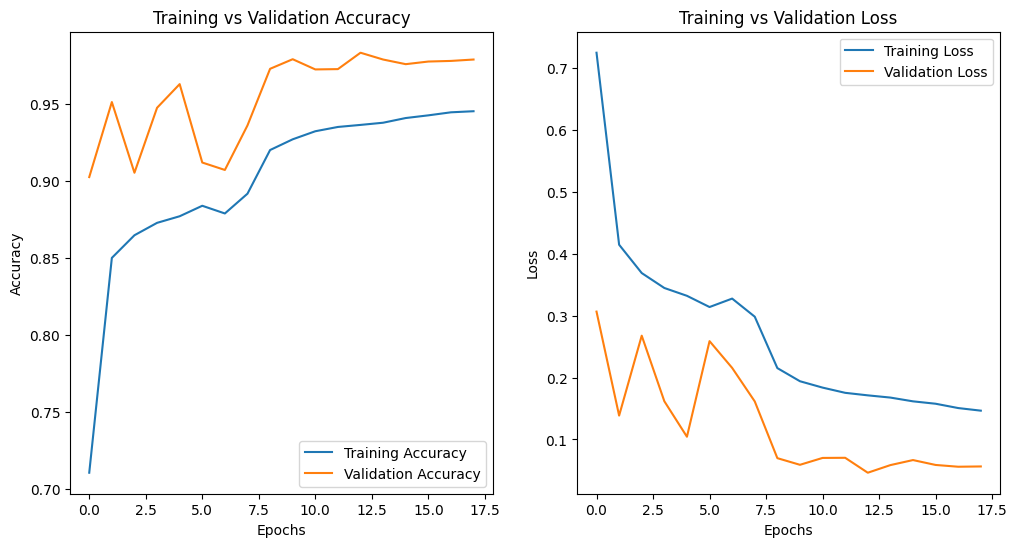

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


2025/03/03 03:48:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/03 03:49:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-03-03 03:49:05,932] Trial 3 finished with value: 0.6840258948287297 and parameters: {'learning_rate': 0.006590672650170811, 'batch_size': 64}. Best is trial 0 with value: 0.8167811812222985.
<ipython-input-32-953aa02cc7db>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Test Precision: 0.6338
Test Recall: 0.9113
Test F1 Score: 0.6840
Test Accuracy: 0.8727
Test AUC-ROC: 0.9861


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 187, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_72 (Conv1D)                   │ (None, 183, 16)             │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 179, 16)             │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 89, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_74 (Conv1D)                   │ (None, 87, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_75 (Conv1D)                   │ (None, 85, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 42, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_76 (Conv1D)                   │ (None, 40, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_77 (Conv1D)                   │ (None, 38, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_78 (Conv1D)                   │ (None, 17, 256)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_79 (Conv1D)                   │ (None, 15, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_9               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3_mitbih (Dense)               │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,901 (995.71 KB)

 Trainable params: 254,901 (995.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.95707, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 21s - 15ms/step - accuracy: 0.7135 - loss: 0.7154 - val_accuracy: 0.9571 - val_loss: 0.1729 - learning_rate: 0.0026
Epoch 2/100

Epoch 2: val_accuracy improved from 0.95707 to 0.95858, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 6s - 4ms/step - accuracy: 0.8744 - loss: 0.3479 - val_accuracy: 0.9586 - val_loss: 0.1274 - learning_rate: 0.0026
Epoch 3/100

Epoch 3: val_accuracy improved from 0.95858 to 0.97376, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 7s - 5ms/step - accuracy: 0.8955 - loss: 0.2895 - val_accuracy: 0.9738 - val_loss: 0.0734 - learning_rate: 0.0026
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.97376
1399/1399 - 10s - 7ms/step - accuracy: 0.9108 - loss: 0.2475 - val_accuracy: 0.9667 - val_loss: 0.0905 - learning_rate: 0.0026
Epoch 5/100

Epoch 5: val_accuracy improved from 0.97376 to 0.98180, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 7s - 5ms/step - accuracy: 0.9237 - loss: 0.2146 - val_accuracy: 0.9818 - val_loss: 0.0583 - learning_rate: 0.0026
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.98180
1399/1399 - 6s - 4ms/step - accuracy: 0.9306 - loss: 0.1934 - val_accuracy: 0.9797 - val_loss: 0.0688 - learning_rate: 0.0026
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.98180
1399/1399 - 10s - 7ms/step - accuracy: 0.9399 - loss: 0.1704 - val_accuracy: 0.9763 - val_loss: 0.0620 - learning_rate: 0.0026
Epoch 8/100

Epoch 8: val_accuracy improved from 0.98180 to 0.98874, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 7s - 5ms/step - accuracy: 0.9415 - loss: 0.1665 - val_accuracy: 0.9887 - val_loss: 0.0338 - learning_rate: 0.0026
Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.98874
1399/1399 - 9s - 6ms/step - accuracy: 0.9453 - loss: 0.1554 - val_accuracy: 0.9871 - val_loss: 0.0407 - learning_rate: 0.0026
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.98874
1399/1399 - 6s - 4ms/step - accuracy: 0.9507 - loss: 0.1435 - val_accuracy: 0.9859 - val_loss: 0.0397 - learning_rate: 0.0026
Epoch 11/100

Epoch 11: val_accuracy did not improve from 0.98874

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002636752557009459.
1399/1399 - 6s - 4ms/step - accuracy: 0.9499 - loss: 0.1450 - val_accuracy: 0.9751 - val_loss: 0.0611 - learning_rate: 0.0026
Epoch 12/100

Epoch 12: val_accuracy improved from 0.98874 to 0.99085, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 11s - 8ms/step - accuracy: 0.9666 - loss: 0.0955 - val_accuracy: 0.9909 - val_loss: 0.0263 - learning_rate: 2.6368e-04
Epoch 13/100

Epoch 13: val_accuracy did not improve from 0.99085
1399/1399 - 7s - 5ms/step - accuracy: 0.9706 - loss: 0.0837 - val_accuracy: 0.9892 - val_loss: 0.0292 - learning_rate: 2.6368e-04
Epoch 14/100

Epoch 14: val_accuracy improved from 0.99085 to 0.99286, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 6s - 5ms/step - accuracy: 0.9733 - loss: 0.0764 - val_accuracy: 0.9929 - val_loss: 0.0227 - learning_rate: 2.6368e-04
Epoch 15/100

Epoch 15: val_accuracy improved from 0.99286 to 0.99367, saving model to /content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5


1399/1399 - 11s - 8ms/step - accuracy: 0.9748 - loss: 0.0729 - val_accuracy: 0.9937 - val_loss: 0.0210 - learning_rate: 2.6368e-04
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.99367
1399/1399 - 7s - 5ms/step - accuracy: 0.9750 - loss: 0.0697 - val_accuracy: 0.9935 - val_loss: 0.0213 - learning_rate: 2.6368e-04
Epoch 17/100

Epoch 17: val_accuracy did not improve from 0.99367
1399/1399 - 10s - 7ms/step - accuracy: 0.9757 - loss: 0.0685 - val_accuracy: 0.9927 - val_loss: 0.0225 - learning_rate: 2.6368e-04
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.99367

Epoch 18: ReduceLROnPlateau reducing learning rate to 2.6367526152171196e-05.
1399/1399 - 10s - 7ms/step - accuracy: 0.9771 - loss: 0.0653 - val_accuracy: 0.9933 - val_loss: 0.0205 - learning_rate: 2.6368e-04
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.99367
1399/1399 - 7s - 5ms/step - accuracy: 0.9782 - loss: 0.0617 - val_accuracy: 0.9935 - val_loss: 0.0191 - learning_rate: 2.6368e-05
Epoc

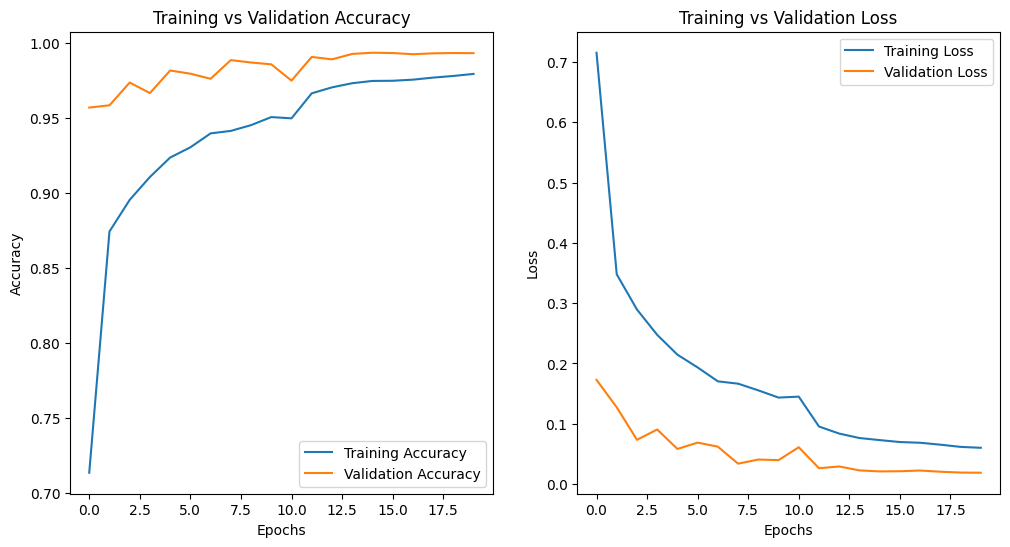

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


2025/03/03 03:52:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/03 03:52:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-03-03 03:52:14,836] Trial 4 finished with value: 0.801341641000975 and parameters: {'learning_rate': 0.00263675248839193, 'batch_size': 64}. Best is trial 0 with value: 0.8167811812222985.


Test Precision: 0.7402
Test Recall: 0.9298
Test F1 Score: 0.8013
Test Accuracy: 0.9481
Test AUC-ROC: 0.9915
Best trial: 0.8167811812222985
Best trial hyperparameters: {'learning_rate': 0.0004672427378539449, 'batch_size': 32}


In [32]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    mlflow.set_experiment('ECG_Heartbeat_Classification_Experiment')

    # Start an MLFlow run for each trial
    with mlflow.start_run():
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('batch_size', batch_size)

        # Get the model
        model = get_model(learning_rate, batch_size)

        # Callbacks
        file_path = "/content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5"
        checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
        redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
        callbacks_list = [checkpoint, early, redonplat]

        # Train the model
        history = model.fit(X_train, Y_train, epochs=100, validation_split=0.1, callbacks=callbacks_list, batch_size=batch_size, verbose=2)

        # Load the best model weights after training
        model.load_weights(file_path)

        # Plot the learning curves
        plot_learning_curves(history)

        # Predict the test data
        pred_test = model.predict(X_test)
        pred_test_class = np.argmax(pred_test, axis=-1)

        # Evaluate metrics
        precision = precision_score(Y_test, pred_test_class, average='macro')
        recall = recall_score(Y_test, pred_test_class, average='macro')
        f1 = f1_score(Y_test, pred_test_class, average='macro')
        accuracy = accuracy_score(Y_test, pred_test_class)
        roc_auc = roc_auc_score(Y_test, pred_test, multi_class='ovr', average='macro')

        # Log metrics to MLFlow
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1_score', f1)
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('roc_auc', roc_auc)

        # Log the model
        mlflow.keras.log_model(model, "model")

        # Print evaluation metrics
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test AUC-ROC: {roc_auc:.4f}")

        # Return the f1 score for optimization
        return f1  # This will be used by Optuna to optimize the model

# Run the optimization process
study = optuna.create_study(direction='maximize')  # We want to maximize F1 score
study.optimize(objective, n_trials=5)  # Run 5 trials for hyperparameter tuning

# Print best hyperparameters and score
print(f"Best trial: {study.best_trial.value}")
print(f"Best trial hyperparameters: {study.best_trial.params}")

# Model Evaluation

In this section, we performed **hyperparameter tuning** using **Optuna** to optimize the model for ECG heartbeat classification. The goal was to maximize the **F1 score** by tuning the following hyperparameters:

- **Learning Rate**: Controls the step size during gradient descent optimization.
- **Batch Size**: The number of samples processed before updating model weights.

## Hyperparameter Tuning Process

We conducted **5 trials** using **Optuna**, exploring combinations of **learning rate** and **batch size** from the following ranges:

- **Learning Rate**: Log-uniform distribution from 1e-5 to 1e-2.
- **Batch Size**: Categorical values [32, 64, 128].

During each trial, we trained the model and evaluated it on the test set. The following metrics were logged:

- **Precision**
- **Recall**
- **F1 Score**
- **Accuracy**
- **AUC-ROC**

### Best Trial Results

The **best trial** achieved the highest **F1 score** of **0.8168** with the following hyperparameters:

- **Learning Rate**: 0.0004672
- **Batch Size**: 32

### Evaluation Metrics for the Best Model

After hyperparameter tuning, the model was evaluated on the test set, and the following results were obtained:

- **Test Precision**: 0.7402
- **Test Recall**: 0.9298
- **Test F1 Score**: 0.8013
- **Test Accuracy**: 0.9481
- **Test AUC-ROC**: 0.9915

### Conclusion

The model's performance on the test set, with an **F1 score of 0.8168** and **AUC-ROC of 0.9915**, suggests that it effectively distinguishes between ECG heartbeat categories. The high **recall** indicates that the model is good at identifying the positive class, but there is potential to improve **precision** to reduce false positives.



In [ ]:
best_model_path = "/content/drive/MyDrive/ECG Classification/models/baseline_cnn_mitbih.h5"

# Assuming `model` is the trained Keras model
model.save(best_model_path)  # Save the model in .h5 format

print(f"Best model saved at: {best_model_path}")